# Demand Estimation in Python and R

## Advanced Quantitative Marketing - Arjun Gopinath

In this Jupyter notebook, I display all relevant results from the demand estimation assignment. The model follows Guadagni and Little (1983).

In [1]:
# Standard Python imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Imports for displaying tables in Jupyter notebooks

from IPython.display import display, HTML
import tabulate

# Frequently used commands
inv, ax = np.linalg.inv, np.newaxis

matplotlib.rcParams['text.usetex'] = True

<ipython-input-1-b1abb32e66e8>:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Sized, KeysView, Sequence


In [3]:
# Setting up bayesm package from R.

library(data.table)
library(tidyr)
library(bayesm)
library(parallel)
library(ggplot2)
library(MCMCpack)

## Part 1 - Microeconometrics of Consumer Demand

The retained households in the datasets have purchased peanut butter in one of the top two chains during the sample period (1993-1995). The eight top-selling peanut butter products are included in the sample. There is also a ninth “no-purchase” option. Each trip has nine observations associated with it containing the price of each alternative, along with the choice made.


In [4]:
%put data --to R

# Importing the dataset into Pandas.

data = pd.read_csv('Raw/pbout.txt', sep=" ")
data.reset_index(inplace=True) 
data.dropna(axis='columns', inplace=True)
data.columns = ['PanelID', 'Date', 'Choice', 'Price',
                'Feature', 'Display', 'Loyalty']
data = data.astype({'PanelID': 'int64', 'Date': 'int64',
                  'Choice': 'int8', 'Feature': 'int8',
                  'Display': 'int8', 'Loyalty': 'int8'})

# Creating product number column.

data['Product'] = list(np.arange(9) + 1) * int(len(data)/9)

# Generating summary statistics by product number.

sum_stat1 = data.groupby(['Product'])[['Loyalty', 'Display', 'Feature']].agg(['mean','std'])
sum_stat2 = data.groupby(['Product'])[['Price']].agg(['mean','std', 'median', 'max', 'min'])

sum_stat = pd.concat([sum_stat2, sum_stat1], axis=1)

In [5]:
%put data --to R

# Reshape dataframe from long to wide, set product-specific columns for price, feature, loyalty, display.

data = data.pivot_table(index=['PanelID', 'Date', 'Choice'], 
                        columns='Product',
                        values=['Price', 'Feature', 'Loyalty', 'Display'])

data.columns = [f'{i}_{j}' for i, j in data.columns]
data = data.reset_index()

### Summary Statistics

I have included a bar graph that captures the frequency of choices made by the consumers in the panel over time. The log-scale was necessary due to the sheer order of magnitude difference between the frequency of choosing a product alternative versus the outside option. It is clear that the product alternatives are chosen with relatively similar frequencies, with product 7 being the most popular throughout the time horizon, and product 8 being the least popular.

In [6]:
# Obtaining frequency data for product choices made by each consumer.

choice_freq = pd.Series(data['Choice'].value_counts())
choice_freq.sort_index(inplace=True)                                                                                                                                                                                                                                                                                                                                                                 

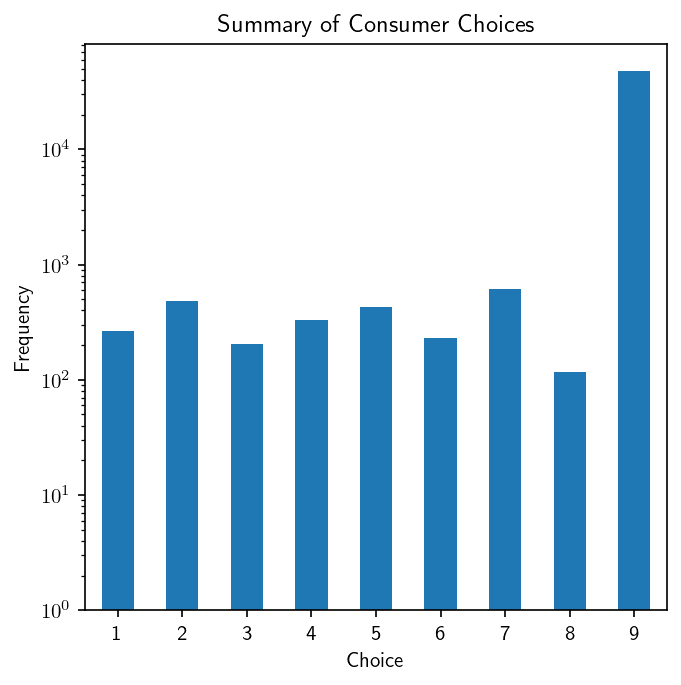

In [7]:
# Generating frequency plot.

fig1 = plt.figure(figsize=(5, 5), dpi=150);
choice_freq.plot.bar(rot=0, log=True, 
                     xlabel='Choice', ylabel='Frequency', 
                     title='Summary of Consumer Choices');

In [8]:
header_stat = ['Product', 'Price Mean', 'Price S.D.', 
               'Price Median', 'Price Max.', 'Price Min.',
               'Loyalty Mean', 'Loyalty S.D.',
               'Display Mean', 'Display S.D.',
               'Feature Mean', 'Feature S.D.']

display(HTML(tabulate.tabulate(sum_stat, tablefmt='html', headers=header_stat)))

Product,Price Mean,Price S.D.,Price Median,Price Max.,Price Min.,Loyalty Mean,Loyalty S.D.,Display Mean,Display S.D.,Feature Mean,Feature S.D.
1,0.135378,0.0111028,0.143889,0.143889,0.107222,0.0738791,0.261577,0,0,0.029319,0.168701
2,0.125268,0.0105207,0.121111,0.147778,0.0994444,0.151426,0.358467,0.0112189,0.105325,0.0281163,0.165307
3,0.132444,0.0065401,0.1325,0.1425,0.106786,0.0764423,0.265707,0.0303048,0.171426,0.0404787,0.197081
4,0.151742,0.0127405,0.153125,0.178125,0.111875,0.0858867,0.280199,0.00577704,0.0757877,0.0546946,0.227385
5,0.130442,0.00914118,0.129444,0.147778,0.11,0.118005,0.322618,0,0,0.0930439,0.290497
6,0.133229,0.00666111,0.133214,0.1425,0.0782143,0.0634094,0.2437,0.00270121,0.0519034,0.0343073,0.182019
7,0.134039,0.0108634,0.132222,0.147778,0.0994444,0.172523,0.377838,0,0,0.0548918,0.227771
8,0.138098,0.00693279,0.1425,0.1425,0.0936905,0.0436729,0.204368,0,0,0.0111597,0.10505
9,0,0,0,0,0,0,0,0,0,0,0


I have used the SOS-notebook feature in order to switch between Python and R as needed, due to the `bayesm` package not having a suitable Python equivalent. I do hope to have some of these estimation procedures coded up on my own by the summer!

In [6]:
base_seed       <-  1112L
num_choices     <-  9L
bayesm_R        <-  50000L # 
bayesm_keep     <-  5L
bayesm_disp     <-  10000L
bayesm_burnin   <-  5000L / bayesm_keep # Use first 1000 draws as burn in

In [7]:
# set MCMC specification

MCMCspec <- list(R=bayesm_R, keep=bayesm_keep, nprint=bayesm_disp)

In [8]:
#' Runs the bayesm::rmnlIndepMetrop algorithm for a given model specification
#'
#' @param Data - List containing features of the data: choice data, covariates used in MNL, 
#'               number of alternative-specific covariates and flag for inclusion of intercepts (list)
#' @param Prior - Prior specification including prior precision matrix and prior mean (list)
#' @param MCMCspec - Specification for MCMC algorithm: 
#'               number of MCMC draws, thinnng parameter, estimated time remaining (list)
#' @return Res_MNLIndep - Model output from bayesm::rmnlIndepMetrop (list)

estimate_MNL <- function(
    Data = list(choice, covariate, num_altcovar, intercept = F, num_choices = num_choices),
    Prior = list(), 
    MCMCspec = list(R, keep, nprint)) {
    
  # Using the Create X routine from bayesm
  covar_MNL <- createX(p = Data$num_choices, na = Data$num_altcovar,
                       nd = 0, Xa = Data$covariate, Xd = NULL, INT = Data$intercept)
  # Estimate mnl
  Res_MNLIndep <- rmnlIndepMetrop(Data = list(y = Data$choice,
                                              X = covar_MNL,
                                              p = Data$num_choices), 
                                  Prior = Prior,
                                  Mcmc = MCMCspec)
  # Return output
  return(Res_MNLIndep)
}

In [9]:
#' Computes posterior log-likelihood for each specified with top and bottom 2.5% trimmed
#'
#' @param MCMC_LL Vector of log-likehoods (numeric)
#' @return The posterior log-likelihood (numeric)

logMargDenNRTrim <- function(MCMC_LL)
{
  quantiles  <- quantile(MCMC_LL, c(2.5,97.5)/100)
  postLL     <- (logMargDenNR(MCMC_LL[which(MCMC_LL > quantiles[[1]] & MCMC_LL < quantiles[[2]])]))
    
  return(postLL)
}

In [10]:
#' Computes Posterior Mean, 95% CI and posterior LL for given MCMC Model and feature_names
#'
#' @param Res_MNLIndep Model output from bayesm::rmnlIndepMetrop (list)
#' @param feature_names A vector of feature names (character)
#' @return A data.table of the posterior mean and 95% CI (data.table)

credInt_MCMC <- function(Res_MNLIndep, feature_names)
{
  beta_draw = Res_MNLIndep$betadraw 
  model_LL = as.matrix(Res_MNLIndep$loglike[-(1:(bayesm_burnin)), ])
  out_DT <- data.table(do.call(rbind, list(Mean  =   apply(beta_draw, 2, mean),
                                           Lower =   apply(beta_draw, 2, function(x) quantile(x, 0.025)),
                                           Upper =   apply(beta_draw, 2, function(x) quantile(x, 0.975)),
                                           PostAll = logMargDenNR(model_LL),
                                           PosTrim = logMargDenNRTrim(Res_MNLIndep$loglike)
                                          )))
  setnames(out_DT, names(out_DT), feature_names)
  out_DT[, Statistic := c("Mean", "Lower CI", "Upper CI", "Post. LL","Post. LL (Trim)" )]
  setcolorder(out_DT, c("Statistic", feature_names))
  return(out_DT)
}

### Specification 1: Price only

In [11]:
spec1 = paste0("Price_", 1:9)

In [11]:
# Prior specifications
priorTypes = list(list(), list(A = diag(0.25, 1), betabar = rep(5, 1)))

# Parallel Setup - cluster of nodes.
cl <- makeCluster(2)

# Import required packages and list into each node.
clusterEvalQ(cl, {
    library(bayesm)
    library(data.table)       
})

clusterExport(cl, c("data", "spec1", "priorTypes", "base_seed",
                    "num_choices", "estimate_MNL", "MCMCspec"))

# Using parLapply to create the longitudinal dataset
spec1MNLRes <- parLapply(cl, 1:2, function(priorNumber) {
    
    set.seed(base_seed + priorNumber)
    
    out <- estimate_MNL(Data = list(choice = data$Choice,
                                    covariate = data[, spec1],
                                    num_altcovar = 1, 
                                    intercept = F, 
                                    num_choices = num_choices),
                        Prior = priorTypes[[priorNumber]], 
                        MCMCspec = MCMCspec)

    list(prior=priorTypes[[priorNumber]], result = out)
});

# Close the parallel cluster setup.
stopCluster(cl) 

[[1]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[2]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"

In [12]:
%put res_spec1_noprior --to Python3
%put res_spec1_prior --to Python3

res_spec1_noprior <- credInt_MCMC(Res_MNLIndep=spec1MNLRes[[1]]$result, feature_names='Price')
res_spec1_noprior <- transpose(res_spec1_noprior, make.names = "Statistic", keep.names = 'Variable')
res_spec1_noprior <- res_spec1_noprior[, 'Model' := 'Specification 1']

res_spec1_prior <- credInt_MCMC(Res_MNLIndep=spec1MNLRes[[2]]$result, feature_names='Price')
res_spec1_prior <- transpose(res_spec1_prior, make.names = "Statistic", keep.names = 'Variable')
res_spec1_prior <- res_spec1_prior[, 'Model' := 'Specification 1 (Alt. Prior)']

In [15]:
res_spec1_prior['Post. LL (Trim)'] = res_spec1_prior['Post. LL (Trim)'].mean()
res_spec1_noprior['Post. LL (Trim)'] = res_spec1_noprior['Post. LL (Trim)'].mean()

res_spec1 = pd.concat([res_spec1_noprior, res_spec1_prior])

res_spec1 = res_spec1.set_index(['Model', 'Post. LL', 'Post. LL (Trim)', 'Variable'])

res_spec1['CI'] = '[' + res_spec1['Lower CI'].round(5).astype(str) + ',' + res_spec1['Upper CI'].round(5).astype(str) + ']'

res_spec1

,,,,Mean,Lower CI,Upper CI,CI
Model,Post. LL,Post. LL (Trim),Variable,,,,
Specification 1,-15926.308613,-15925.644365,Price,-37.406137,-37.699199,-37.104688,"[-37.6992,-37.10469]"
Specification 1 (Alt. Prior),-15931.604522,-15928.074227,Price,-37.178060,-37.475111,-36.883617,"[-37.47511,-36.88362]"


### Specification 2: Alternative-specifc Dummies + Price

In [16]:
# Prior specifications
priorTypes2 = list(list(), list(A = diag(0.25, 9), betabar = rep(1, 9)))

# Parallel Setup - cluster of nodes.
cl <- makeCluster(2)

# Import required packages and list into each node.
clusterEvalQ(cl, {
    library(bayesm)
    library(data.table)       
})

clusterExport(cl, c("data", "spec1", "priorTypes2", "base_seed",
                    "num_choices", "estimate_MNL", "MCMCspec"))

# Using parLapply to create the longitudinal dataset
spec2MNLRes <- parLapply(cl, 1:2, function(priorNumber) {
    
    set.seed(base_seed + priorNumber)
    
    out <- estimate_MNL(Data = list(choice = data$Choice,
                                    covariate = data[, spec1],
                                    num_altcovar = 1, 
                                    intercept = T, 
                                    num_choices = num_choices),
                        Prior = priorTypes2[[priorNumber]], 
                        MCMCspec = MCMCspec)

    list(prior=priorTypes2[[priorNumber]], result = out)
});

# Close the parallel cluster setup.
stopCluster(cl) 

[[1]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[2]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"

In [17]:
%put res_spec2_noprior --to Python3
%put res_spec2_prior --to Python3

res_spec2_noprior <- credInt_MCMC(Res_MNLIndep=spec2MNLRes[[1]]$result, 
                                  feature_names=c(paste0("Intercept_", 1:8), "Price"))
res_spec2_noprior <- transpose(res_spec2_noprior, make.names = "Statistic", keep.names = 'Variable')
res_spec2_noprior <- res_spec2_noprior[, 'Model' := 'Specification 2']

res_spec2_prior <- credInt_MCMC(Res_MNLIndep=spec2MNLRes[[2]]$result, 
                                feature_names=c(paste0("Intercept_", 1:8), "Price"))
res_spec2_prior <- transpose(res_spec2_prior, make.names = "Statistic", keep.names = 'Variable')
res_spec2_prior <- res_spec2_prior[, 'Model' := 'Specification 2 (Alt. Prior)']

In [19]:
res_spec2_prior['Post. LL (Trim)'] = res_spec2_prior['Post. LL (Trim)'].mean()
res_spec2_noprior['Post. LL (Trim)'] = res_spec2_noprior['Post. LL (Trim)'].mean()

res_spec2 = pd.concat([res_spec2_noprior, res_spec2_prior])

res_spec2 = res_spec2.set_index(['Model', 'Post. LL', 'Post. LL (Trim)', 'Variable'])

res_spec2['CI'] = '[' + res_spec2['Lower CI'].round(5).astype(str) + ',' + res_spec2['Upper CI'].round(5).astype(str) + ']'

res_spec2

Mean  \
Model                        Post. LL      Post. LL (Trim) Variable                 
Specification 2              -15648.343530 -15925.644365   Intercept_1  -1.919890   
                                                           Intercept_2  -1.546561   
                                                           Intercept_3  -2.227476   
                                                           Intercept_4  -1.311141   
                                                           Intercept_5  -1.532024   
                                                           Intercept_6  -2.092873   
                                                           Intercept_7  -1.096821   
                                                           Intercept_8  -2.646113   
                                                           Price       -24.587003   
Specification 2 (Alt. Prior) -15668.364279 -15928.074227   Intercept_1  -3.134249   
                                                           Intercept_2  -2.634119   
                                                           Intercept_3  -3.450904   
                                                           Intercept_4  -2.641110   
                                                           Intercept_5  -2.715233   
                                                           Intercept_6  -3.286386   
                                                           Intercept_7  -2.311940   
                                                           Intercept_8  -3.911305   
                                                           Price       -15.471251   

                                                                         Lower CI  \
Model                        Post. LL      Post. LL (Trim) Variable                 
Specification 2              -15648.343530 -15925.644365   Intercept_1  -2.383500   
                                                           Intercept_2  -1.966187   
                                                           Intercept_3  -2.693447   
                                                           Intercept_4  -1.817879   
                                                           Intercept_5  -1.976771   
                                                           Intercept_6  -2.554396   
                                                           Intercept_7  -1.545422   
                                                           Intercept_8  -3.141740   
                                                           Price       -27.908593   
Specification 2 (Alt. Prior) -15668.364279 -15928.074227   Intercept_1  -3.372050   
                                                           Intercept_2  -2.852739   
                                                           Intercept_3  -3.712667   
                                                           Intercept_4  -2.945866   
                                                           Intercept_5  -2.959568   
                                                           Intercept_6  -3.495629   
                                                           Intercept_7  -2.704653   
                                                           Intercept_8  -4.297588   
                                                           Price       -18.976407   

                                                                         Upper CI  \
Model                        Post. LL      Post. LL (Trim) Variable                 
Specification 2              -15648.343530 -15925.644365   Intercept_1  -1.458022   
                                                           Intercept_2  -1.126368   
                                                           Intercept_3  -1.762455   
                                                           Intercept_4  -0.807346   
                                                           Intercept_5  -1.094526   
                                                           Intercept_6  -1.63449

### Specification 3: Alternative Dummies + Price + Feature + Display

In [12]:
spec3 = c(spec1, paste0("Display_", 1:9), paste0("Feature_", 1:9))

In [21]:
# Prior specifications
priorTypes3 = list(list(), list(A = diag(0.25, 11), betabar = rep(1, 11)))

# Parallel Setup - cluster of nodes.
cl <- makeCluster(2)

# Import required packages and list into each node.
clusterEvalQ(cl, {
    library(bayesm)
    library(data.table)       
})

clusterExport(cl, c("data", "spec3", "priorTypes3", "base_seed",
                    "num_choices", "estimate_MNL", "MCMCspec"))

# Using parLapply to create the longitudinal dataset
spec3MNLRes <- parLapply(cl, 1:2, function(priorNumber) {
    
    set.seed(base_seed + priorNumber)
    
    out <- estimate_MNL(Data = list(choice = data$Choice,
                                    covariate = data[, spec3],
                                    num_altcovar = 3, 
                                    intercept = T, 
                                    num_choices = num_choices),
                        Prior = priorTypes3[[priorNumber]], 
                        MCMCspec = MCMCspec)

    list(prior=priorTypes3[[priorNumber]], result = out)
});


[[1]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[2]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"

In [22]:
%put res_spec3_noprior --to Python3
%put res_spec3_prior --to Python3

res_spec3_noprior <- credInt_MCMC(Res_MNLIndep=spec3MNLRes[[1]]$result, 
                                  feature_names=c(paste0("Intercept_", 1:8), "Price", "Display", "Feature"))
res_spec3_noprior <- transpose(res_spec3_noprior, make.names = "Statistic", keep.names = 'Variable')
res_spec3_noprior <- res_spec3_noprior[, 'Model' := 'Specification 3']

res_spec3_prior <- credInt_MCMC(Res_MNLIndep=spec3MNLRes[[2]]$result, 
                                feature_names=c(paste0("Intercept_", 1:8), "Price", "Display", "Feature"))
res_spec3_prior <- transpose(res_spec3_prior, make.names = "Statistic", keep.names = 'Variable')
res_spec3_prior <- res_spec3_prior[, 'Model' := 'Specification 3 (Alt. Prior)']

In [24]:
res_spec3_prior['Post. LL (Trim)'] = res_spec3_prior['Post. LL (Trim)'].mean()
res_spec3_noprior['Post. LL (Trim)'] = res_spec3_noprior['Post. LL (Trim)'].mean()

res_spec3 = pd.concat([res_spec3_noprior, res_spec3_prior])

res_spec3 = res_spec3.set_index(['Model', 'Post. LL', 'Post. LL (Trim)', 'Variable'])

res_spec3['CI'] = '[' + res_spec3['Lower CI'].round(5).astype(str) + ',' + res_spec3['Upper CI'].round(5).astype(str) + ']'

The results from each specification are compiled below. 

- If we look at the price coefficients we see that the sign is correct. Price coefficient magnitude is significantly reduced once we introduce product alternative fixed effect. Finally, including also the dummy for promotions further reduces the estimated price coefficients. This gives us a sense, that not only prices determine demand of peanut butter.

In [25]:
results_part1 = pd.concat([res_spec1, res_spec2, res_spec3])
results_part1 = results_part1.drop(['Lower CI', 'Upper CI'], axis=1)
results_part1

Mean  \
Model                        Post. LL      Post. LL (Trim) Variable                 
Specification 1              -15926.308613 -15925.644365   Price       -37.406137   
Specification 1 (Alt. Prior) -15931.604522 -15928.074227   Price       -37.178060   
Specification 2              -15648.343530 -15925.644365   Intercept_1  -1.919890   
                                                           Intercept_2  -1.546561   
                                                           Intercept_3  -2.227476   
                                                           Intercept_4  -1.311141   
                                                           Intercept_5  -1.532024   
                                                           Intercept_6  -2.092873   
                                                           Intercept_7  -1.096821   
                                                           Intercept_8  -2.646113   
                                                           Price       -24.587003   
Specification 2 (Alt. Prior) -15668.364279 -15928.074227   Intercept_1  -3.134249   
                                                           Intercept_2  -2.634119   
                                                           Intercept_3  -3.450904   
                                                           Intercept_4  -2.641110   
                                                           Intercept_5  -2.715233   
                                                           Intercept_6  -3.286386   
                                                           Intercept_7  -2.311940   
                                                           Intercept_8  -3.911305   
                                                           Price       -15.471251   
Specification 3              -15634.497378 -15631.234331   Intercept_1  -2.265227   
                                                           Intercept_2  -1.882407   
                                                           Intercept_3  -2.614945   
                                                           Intercept_4  -1.708955   
                                                           Intercept_5  -1.891808   
                                                           Intercept_6  -2.447234   
                                                           Intercept_7  -1.451654   
                                                           Intercept_8  -2.990257   
                                                           Price       -22.090366   
                                                           Display       0.753461   
                                                           Feature       0.313595   
Specification 3 (Alt. Prior) -15652.606313 -15646.365795   Intercept_1  -3.429619   
                                                           Intercept_2  -2.932318   
                                                           Intercept_3  -3.740259   
                                                           Intercept_4  -2.964000   
                                                           Intercept_5  -3.056241   
                                                           Intercept_6  -3.539746   
                                                           Intercept_7  -2.581917   
                                                           Intercept_8  -4.235222   
                                                           Price       -13.525183   
                                                           Display       0.856818   
                                                           Feature       0.422181   

                                                                                           CI  
Model                        Post. LL      Post. LL (Trim) Variable                            
Specification 1              -15926.308613 -15925.644365   Price         [-37.6992,-37.10469]  
Specification 1 (Alt. Prior) -15931.604522 -1592

## Part 2 - Heterogeneity in Preferences

To control for between-household, persistent heterogeneity in tastes, we estimate the random coefficients multinomial conditional logit demand system using MCMC

In [13]:
#'' Generates the longitudinal data input for the bayesm::rhierMnlRwMixture algorithm
#'
#' @param Data - List containing features of the data: panel ID list, choice data, covariates used in MNL, 
#'               number of alternative-specific covariates and flag for inclusion of intercepts (list)
#' @return lgtData - Choice and covariate data by each cross-sectional unit in the panel (list)

generateLgtData <- function (
    
    Data = list(panelID, choice, covariate, num_altcovar, intercept = F, num_choices = num_choices)) {
        
    # Assemble the unique panel IDs.
    uniqueID <- unique(Data$panelID)
                            
    # Parallel Setup - cluster of nodes.
    numCores <- detectCores() - 2
    cl <- makeCluster(numCores)

    # Import required packages and list into each node.
    clusterEvalQ(cl, {
        library(bayesm)
        library(data.table)       
    })
    clusterExport(cl, "Data", envir=environment())
    
    # Using parLapply to create the longitudinal dataset
    lgtData <- parLapply(cl, uniqueID, function(panel_index)
    {

        indx_i <- which(Data$panelID == panel_index)

        y  <- as.matrix(Data$choice[indx_i])

        covar_MNL <- createX(p = Data$num_choices, 
                                 na = Data$num_altcovar, nd = 0,
                                 Xa = Data$covariate[indx_i, ], Xd = NULL,
                                 INT = Data$intercept)

        list(y = y, X = covar_MNL)
    })
        
    # Close the parallel cluster setup.
    stopCluster(cl)
        
    return(lgtData)
        
    }

In [14]:
#' Runs the bayesm::rhierMnlRwMixture algorithm for a given model specification.
#' @param lgtData - Choice and covariate data by each cross-sectional unit in the panel (list)
#' @param Prior - Prior specification including number of components in the normal mixture,
#'               prior precision matrix and prior mean (list)
#' @param MCMCspec - Specification for MCMC algorithm: 
#'               number of MCMC draws, thinnng parameter, estimated time remaining (list)
#' @return Res_MNLMix - Model output from bayesm::rhierMnlRwMixture (list)

estimate_HetMNL <- function(
    lgtData = list(y, X),
    num_choices = num_choices,
    Prior = list(ncomp = 1), 
    MCMCspec = list(R, keep, nprint)) {
    
    # Implement the MNL mixture-of-normals Random Walk MCMC algorithm
    
    Res_MNLMix <- rhierMnlRwMixture(Data = list(lgtdata = lgtData, p = num_choices), 
                                    Prior = Prior, 
                                    Mcmc = MCMCspec)
    
    return(Res_MNLMix)
    
}

In [15]:
#' Computes posterior log-likelihood and trimmed posterior log-likelihood for the Random Walk MCMC mixture of normals model.
#'
#' @param specHetRes A list of component numbers and rhierMnlRwMixture results (list)
#' @param burn_in Number of draws to discard as burn in (integer)
#' @return A data.table of the requested statistics (data.table)

logMargDenNRHet <- function(specHetRes, burn_in = bayesm_burnin)
{ 

  LLtable <- rbindlist(lapply(lapply(specHetRes, '[[', 'n'), function(component_num)
  {
    hier_model      <-   specHetRes[[component_num]]$result
    LL_value        <-   logMargDenNR(hier_model$loglike[-(1:bayesm_burnin)])
    LL_value_trim   <-   logMargDenNRTrim(hier_model$loglike[-(1:bayesm_burnin)])
    data.table(component_number           =   component_num,
               log_marg_likelihood        =   LL_value,
               log_marg_likelihood_trim   =   LL_value_trim
               )
  }))
    
  setnames(LLtable, names(LLtable), c('Num. Components', 'Post. LL', 'Post. LL (Trim)'))

  return(LLtable)

}

### Specification 1: Price only

In [29]:
lgtData1 <- generateLgtData(Data = list(panelID = data$PanelID, choice = data$Choice,
                                        covariate = data[, spec1], num_altcovar = 1, 
                                        intercept = F, num_choices = num_choices))

# Parallel Setup - cluster of nodes.
numCores <- 5
cl <- makeCluster(numCores)

# Import required packages and list into each node.
clusterEvalQ(cl, {
    library(bayesm)
    library(data.table)       
})

clusterExport(cl, c("lgtData1", "num_choices", "MCMCspec",
                    "base_seed", "estimate_HetMNL"))

# Using parLapply to create the longitudinal dataset
spec1HetRes <- parLapply(cl, 1:5, function(num_comp) {
    
    set.seed(base_seed + num_comp)
    
    out <- estimate_HetMNL(lgtData=lgtData1, 
                          num_choices = num_choices,
                          Prior = list(ncomp = num_comp), 
                          MCMCspec = MCMCspec)

    list(n = num_comp, result = out)
});

# Close the parallel cluster setup.
stopCluster(cl) 


[[1]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[2]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[3]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[4]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[5]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"

In [39]:
%put resHet1 --to Python3

resHet1 <- logMargDenNRHet(specHetRes=spec1HetRes, burn_in=bayesm_burnin)
resHet1[, 'Model':= 'Specification 1']

### Specification 2: Alternative-specifc Dummies + Price

In [30]:
lgtData2 <- generateLgtData(Data = list(panelID = data$PanelID, choice = data$Choice,
                                        covariate = data[, spec1], num_altcovar = 1, 
                                        intercept = T, num_choices = num_choices))

# Parallel Setup - cluster of nodes.
numCores <- 5  
cl <- makeCluster(numCores)

# Import required packages and list into each node.
clusterEvalQ(cl, {
    library(bayesm)
    library(data.table)       
})

clusterExport(cl, c("lgtData2", "num_choices", "MCMCspec",
                    "base_seed", "estimate_HetMNL"))

# Using parLapply to create the longitudinal dataset
spec2HetRes <- parLapply(cl, 1:5, function(num_comp) {
    
    set.seed(base_seed + num_comp)
    
    out <- estimate_HetMNL(lgtData=lgtData2, 
                          num_choices = num_choices,
                          Prior = list(ncomp = num_comp), 
                          MCMCspec = MCMCspec)

    list(n = num_comp, result = out)
});

# Close the parallel cluster setup.
stopCluster(cl) 

[[1]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[2]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[3]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[4]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[5]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"

In [41]:
%put resHet2 --to Python3

resHet2 <- logMargDenNRHet(specHetRes=spec2HetRes, burn_in=bayesm_burnin)
resHet2[, 'Model':= 'Specification 2']

### Specification 3: Alternative Dummies + Price + Feature + Display

In [31]:
lgtData3 <- generateLgtData(Data = list(panelID = data$PanelID, choice = data$Choice,
                                        covariate = data[, spec3], num_altcovar = 3, 
                                        intercept = T, num_choices = num_choices))

# Parallel Setup - cluster of nodes.
numCores <- 5  
cl <- makeCluster(numCores)

# Import required packages and list into each node.
clusterEvalQ(cl, {
    library(bayesm)
    library(data.table)       
})

clusterExport(cl, c("lgtData3", "num_choices", "MCMCspec",
                    "base_seed", "estimate_HetMNL"))

# Using parLapply to create the longitudinal dataset
spec3HetRes <- parLapply(cl, 1:5, function(num_comp) {
    
    set.seed(base_seed + num_comp)
    
    out <- estimate_HetMNL(lgtData=lgtData3, 
                          num_choices = num_choices,
                          Prior = list(ncomp = num_comp), 
                          MCMCspec = MCMCspec)

    list(n = num_comp, result = out)
});

# Close the parallel cluster setup.
stopCluster(cl) 

[[1]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[2]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[3]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[4]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[5]]
[1] "data.table" "bayesm"     "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"

In [42]:
%put resHet3 --to Python3

resHet3 <- logMargDenNRHet(specHetRes=spec3HetRes, burn_in=bayesm_burnin)
resHet3[, 'Model':= 'Specification 3']

In [43]:
results_part2 = pd.concat([resHet1, resHet2, resHet3])
results_part2.set_index([ 'Model', 'Num. Components'], inplace=True)
results_part2

Post. LL  Post. LL (Trim)
Model           Num. Components                               
Specification 1 1               -15250.244826    -15224.196216
                2               -15253.689466    -15233.583170
                3               -15256.935327    -15230.066227
                4               -15255.066081    -15230.678121
                5               -15264.464998    -15230.691434
Specification 2 1               -12509.566932    -12454.269865
                2               -12487.097670    -12426.437723
                3               -12430.350462    -12364.209929
                4               -12390.608700    -12340.119079
                5               -12375.997632    -12335.270447
Specification 3 1               -12471.710248    -12395.052762
                2               -12417.152368    -12362.823435
                3               -12371.271555    -12319.181277
                4               -12363.770429    -12310.607784
                5               -12333.111210    -12263.868072

## Part 3 - Brands and Branding

In [16]:
spec4 = c(spec3, paste0("Loyalty_", 1:9))

In [17]:
brandsMNLRes <- estimate_MNL(Data = list(choice = data$Choice,
                                          covariate = data[, spec4],
                                    num_altcovar = 4, 
                                    intercept = T, 
                                    num_choices = num_choices),
                             Prior = list(), 
                             MCMCspec = MCMCspec)

 table of y values
y
    1     2     3     4     5     6     7     8     9 
  263   486   203   328   431   228   617   117 48045 
 
Starting Independence Metropolis Sampler for Multinomial Logit Model
   50718  obs with  9  alternatives
 
Table of y Values
y
    1     2     3     4     5     6     7     8     9 
  263   486   203   328   431   228   617   117 48045 
Prior Parms: 
betabar
 [1] 0 0 0 0 0 0 0 0 0 0 0 0
A
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12]
 [1,] 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  0.00  0.00  0.00
 [2,] 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00  0.00  0.00  0.00
 [3,] 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00  0.00  0.00  0.00
 [4,] 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00  0.00  0.00  0.00
 [5,] 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00  0.00  0.00  0.00
 [6,] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00  0.00  0.00  0.00
 [7,] 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00  0.00  0.00  0.00
 [8,] 0.00 0.00 0.00 0.00

In [18]:
%put res_spec3_loyalty --to Python3

spec3_loyalty <- credInt_MCMC(Res_MNLIndep=brandsMNLRes, 
                                  feature_names=c(paste0("Intercept_", 1:8), "Price", "Display", "Feature", "Loyalty"))
res_spec3_loyalty <- transpose(spec3_loyalty, make.names = "Statistic", keep.names = 'Variable')
res_spec3_loyalty <- spec3_loyalty[, 'Model' := 'No Heterogeneity']

In [19]:
lgtData4 <- generateLgtData(Data = list(panelID = data$PanelID, choice = data$Choice,
                                        covariate = data[, spec4], num_altcovar = 4, 
                                        intercept = T, num_choices = num_choices))

brandsHetMNLRes <- estimate_HetMNL(lgtData=lgtData4, 
                                   num_choices = num_choices,
                                   Prior = list(ncomp = 5), 
                                   MCMCspec = MCMCspec)

Z not specified
Table of Y values pooled over all units
ypooled
    1     2     3     4     5     6     7     8     9 
  263   486   203   328   431   228   617   117 48045 
 
Starting MCMC Inference for Hierarchical Logit:
   Normal Mixture with 5 components for first stage prior
   9  alternatives;  12  variables in X
   for  544  cross-sectional units
 
Prior Parms: 
nu = 15
V 
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12]
 [1,]   15    0    0    0    0    0    0    0    0     0     0     0
 [2,]    0   15    0    0    0    0    0    0    0     0     0     0
 [3,]    0    0   15    0    0    0    0    0    0     0     0     0
 [4,]    0    0    0   15    0    0    0    0    0     0     0     0
 [5,]    0    0    0    0   15    0    0    0    0     0     0     0
 [6,]    0    0    0    0    0   15    0    0    0     0     0     0
 [7,]    0    0    0    0    0    0   15    0    0     0     0     0
 [8,]    0    0    0    0    0    0    0   15    0     0     0  

In [28]:
%put res_loyalty_Het3 --to Python3

LLtable <- rbindlist(
  {
    hier_model      <-   brandsHetMNLRes
    LL_value        <-   logMargDenNR(hier_model$loglike[-(1:bayesm_burnin)])
    LL_value_trim   <-   logMargDenNRTrim(hier_model$loglike[-(1:bayesm_burnin)])
    data.table(log_marg_likelihood        =   LL_value,
               log_marg_likelihood_trim   =   LL_value_trim
               )
  }))
    
  setnames(LLtable, names(LLtable), c('Post. LL', 'Post. LL (Trim)'))

   

}

res_loyalty_Het3 <- logMargDenNRHet(specHetRes=list(list(n=5, out=brandsHetMNLRes)),
                                    burn_in=bayesm_burnin)
res_loyalty_Het3[, 'Model':= '5 Components']

ERROR: Error in specHetRes[[component_num]]: subscript out of bounds


Variable res_loyalty_Het3 does not exist


In [ ]:
names(brandsHetMNLRes)